> *ⓒ 2021. leeyoumin All Rights Reserved.*


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/My Drive/myModel

/content/drive/My Drive/myModel


In [3]:
import numpy as np
import pandas as pd
import matplotlib as plt
from sklearn.model_selection import train_test_split
import sklearn
import os
from keras.callbacks import EarlyStopping
import keras

## **폴더 만들기**
#### 모델 실행 후 만들어질 파일들이 저장될거임

In [4]:
def create_directory(directory_path):
    if os.path.exists(directory_path):
        return None
    else:
        try:
            os.makedirs(directory_path)
        except:
            return None
        return directory_path

## **데이터 불러오기**

#### 전체 dataset에서 케라스가 알아서 train과 test로 나누고 싶을 때 이 코드 사용

In [ ]:
def read_dataset(root_dir, dataset_name):
    datasets_dict = {}

    df = np.loadtxt('./ALL_data.csv', delimiter=',')

    x_train, x_test, y_train, y_test = train_test_split(df[:,1:], df[:,0], test_size=0.3)
    print("x_train:", x_train.shape)
    print("x_test: ", x_test.shape)
    print("y_train", y_train.shape)
    print("y_test: ", y_test.shape)

    # znorm
    std_ = x_train.std(axis=1, keepdims=True)
    std_[std_ == 0] = 1.0
    x_train = (x_train - x_train.mean(axis=1, keepdims=True)) / std_
    std_ = x_test.std(axis=1, keepdims=True)
    std_[std_ == 0] = 1.0
    x_test = (x_test - x_test.mean(axis=1, keepdims=True)) / std_
    datasets_dict[dataset_name] = (x_train.copy(), y_train.copy(), x_test.copy(),
                                    y_test.copy())
    return datasets_dict

datasets_dict= read_dataset('', 'handcream')

x_train: (1770, 2000)
x_test:  (759, 2000)
y_train (1770,)
y_test:  (759,)


#### train set과 test set 을 따로 만들었을 경우에는 이 코드를 사용

In [5]:
train_data = np.loadtxt('./dataset.csv', delimiter=',')
test_data = np.loadtxt('./0610_test.csv', delimiter=',')

# test_data = np.loadtxt('./sample1t.csv', delimiter=',')
# test_data = np.loadtxt('./sample2.csv', delimiter=',')
# test_data = np.loadtxt('./sample3.csv', delimiter=',')

x_train = train_data[:,1:]
y_train = train_data[:,0]
x_test = test_data[:,1:]
y_test = test_data[:,0]
print(x_test, y_test)
# znorm
std_ = x_train.std(axis=1, keepdims=True)
std_[std_ == 0] = 1.0
x_train = (x_train - x_train.mean(axis=1, keepdims=True)) / std_
std_ = x_test.std(axis=1, keepdims=True)
std_[std_ == 0] = 1.0
x_test = (x_test - x_test.mean(axis=1, keepdims=True)) / std_

print("x_train:", x_train.shape)
print("x_test: ", x_test.shape)
print("y_train", y_train.shape)
print("y_test: ", y_test.shape)

[[ 0.01765  0.01756  0.01734 ...  0.05155  0.05134  0.05112]
 [-0.07579 -0.07573 -0.0757  ...  0.05886  0.0591   0.0592 ]
 [ 0.01499  0.01477  0.01455 ...  0.0515   0.05127  0.051  ]
 ...
 [ 0.02061  0.02033  0.02005 ...  0.04983  0.04993  0.04999]
 [ 0.0051   0.00461  0.00408 ...  0.05684  0.0569   0.05703]
 [-0.08219 -0.08216 -0.08226 ...  0.07891  0.07827  0.07763]] [3. 1. 3. 2. 1. 3. 2. 1. 1. 3. 2. 3. 3. 1. 1. 1. 3. 3. 3. 1. 3. 1. 2. 3.
 3. 3. 3. 3. 3. 2. 2. 2. 2. 3. 3. 1. 1. 3. 2. 3. 1. 3. 2. 1. 2. 3. 2. 2.
 1. 1. 2. 3. 3. 2. 2. 2. 3. 1. 1. 1. 1. 2. 2. 1. 1. 2. 2. 3. 1. 2. 3. 1.
 3. 3. 2. 2. 2. 2. 3. 1. 1. 2. 1. 1. 1. 2. 1. 2. 2. 1.]
x_train: (390, 1000)
x_test:  (90, 1000)
y_train (390,)
y_test:  (90,)


## **원핫인코딩**

In [6]:
dataset_name = 'handcream'

"""
# 케라스의 train_test_split 함수 썼을 때는 주석 풀고 코드 실행
x_train = datasets_dict[dataset_name][0]
y_train = datasets_dict[dataset_name][1]
x_test = datasets_dict[dataset_name][2]
y_test = datasets_dict[dataset_name][3]
"""

print("x_train:", x_train.shape)
print("x_test: ", x_test.shape)
print("y_train", y_train.shape)
print("y_test: ", y_test.shape)

nb_classes = len(np.unique(np.concatenate((y_train, y_test), axis=0)))
print("class:", nb_classes)
enc = sklearn.preprocessing.OneHotEncoder(categories='auto')
enc.fit(np.concatenate((y_train, y_test), axis=0).reshape(-1, 1))
y_train = enc.transform(y_train.reshape(-1, 1)).toarray()
y_test = enc.transform(y_test.reshape(-1, 1)).toarray()

y_true = np.argmax(y_test, axis=1)

if len(x_train.shape) == 2:
    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
    x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

input_shape = x_train.shape[1:]
# print(x_test, y_test)

output_directory = './resnet_' + dataset_name + '/'
create_directory(output_directory)

x_train: (390, 1000)
x_test:  (90, 1000)
y_train (390,)
y_test:  (90,)
class: 3


## **ResNet 모델**

In [7]:
################### CNN ###################
padding = 'valid'
input_layer = keras.layers.Input(input_shape)

if input_shape[0] < 60: # for italypowerondemand dataset
    padding = 'same'

conv1 = keras.layers.Conv1D(filters=6,kernel_size=7,padding=padding,activation='sigmoid')(input_layer)
conv1 = keras.layers.AveragePooling1D(pool_size=3)(conv1)

conv2 = keras.layers.Conv1D(filters=12,kernel_size=7,padding=padding,activation='sigmoid')(conv1)
conv2 = keras.layers.AveragePooling1D(pool_size=3)(conv2)

flatten_layer = keras.layers.Flatten()(conv2)

output_layer = keras.layers.Dense(units=nb_classes,activation='sigmoid')(flatten_layer)

model = keras.models.Model(inputs=input_layer, outputs=output_layer)
# mean_squared_error
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(),
                metrics=['accuracy'])

file_path = output_directory + 'best_model.hdf5'

early_stopping_callback = EarlyStopping(monitor = 'val_loss', mode='min', patience=20, verbose=1)

model_checkpoint = keras.callbacks.ModelCheckpoint(filepath=file_path, monitor='loss',
                                                    save_best_only=True)

callbacks = [model_checkpoint, early_stopping_callback]

In [ ]:
n_feature_maps = 64

input_layer = keras.layers.Input(input_shape)

# BLOCK 1

conv_x = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=32, padding='same')(input_layer) #8
conv_x = keras.layers.BatchNormalization()(conv_x)
conv_x = keras.layers.Activation('relu')(conv_x)

conv_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=16, padding='same')(conv_x) #5
conv_y = keras.layers.BatchNormalization()(conv_y)
conv_y = keras.layers.Activation('relu')(conv_y)

conv_z = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=8, padding='same')(conv_y) #3
conv_z = keras.layers.BatchNormalization()(conv_z)

# expand channels for the sum
shortcut_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=1, padding='same')(input_layer)
shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

output_block_1 = keras.layers.add([shortcut_y, conv_z])
output_block_1 = keras.layers.Activation('relu')(output_block_1)

# BLOCK 2

conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=32, padding='same')(output_block_1)
conv_x = keras.layers.BatchNormalization()(conv_x)
conv_x = keras.layers.Activation('relu')(conv_x)

conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=16, padding='same')(conv_x)
conv_y = keras.layers.BatchNormalization()(conv_y)
conv_y = keras.layers.Activation('relu')(conv_y)

conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(conv_y)
conv_z = keras.layers.BatchNormalization()(conv_z)

# expand channels for the sum
shortcut_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=1, padding='same')(output_block_1)
shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

output_block_2 = keras.layers.add([shortcut_y, conv_z])
print("output_block_2:", output_block_2)
output_block_2 = keras.layers.Activation('relu')(output_block_2)

# BLOCK 3

conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=32, padding='same')(output_block_2)
conv_x = keras.layers.BatchNormalization()(conv_x)
conv_x = keras.layers.Activation('relu')(conv_x)

conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=16, padding='same')(conv_x)
conv_y = keras.layers.BatchNormalization()(conv_y)
conv_y = keras.layers.Activation('relu')(conv_y)

conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(conv_y)
conv_z = keras.layers.BatchNormalization()(conv_z)

# no need to expand channels because they are equal
shortcut_y = keras.layers.BatchNormalization()(output_block_2)

output_block_3 = keras.layers.add([shortcut_y, conv_z])
output_block_3 = keras.layers.Activation('relu')(output_block_3)
# FINAL

gap_layer = keras.layers.GlobalAveragePooling1D()(output_block_3)
output_layer = keras.layers.Dense(nb_classes, activation='softmax')(gap_layer)

model = keras.models.Model(inputs=input_layer, outputs=output_layer)

model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(),
                metrics=['accuracy'])

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=50, min_lr=0.0001)

file_path = output_directory + 'best_model.hdf5'

early_stopping_callback = EarlyStopping(monitor = 'val_loss', mode='min', patience=20, verbose=1)

model_checkpoint = keras.callbacks.ModelCheckpoint(filepath=file_path, monitor='loss',
                                                    save_best_only=True)

callbacks = [reduce_lr, model_checkpoint, early_stopping_callback]

model.save(output_directory + 'last_model.hdf5')


output_block_2: KerasTensor(type_spec=TensorSpec(shape=(None, 1000, 128), dtype=tf.float32, name=None), name='add_1/add:0', description="created by layer 'add_1'")


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [8]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 994, 6)            48        
_________________________________________________________________
average_pooling1d (AveragePo (None, 331, 6)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 325, 12)           516       
_________________________________________________________________
average_pooling1d_1 (Average (None, 108, 12)           0         
_________________________________________________________________
flatten (Flatten)            (None, 1296)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3891  

## **학습**

In [9]:
# validation_split: train dataset에서 validation dataset으로 분리할 크기 
# 0.2 => 20%
history = model.fit(x_train, y_train, batch_size=16, epochs=100, validation_split=0.2, callbacks=callbacks)

Epoch 1/100
20/20 [==============================] - 42s 29ms/step - loss: 1.2417 - accuracy: 0.3657 - val_loss: 1.1695 - val_accuracy: 0.3333
Epoch 2/100
20/20 [==============================] - 0s 5ms/step - loss: 1.2159 - accuracy: 0.2686 - val_loss: 1.2084 - val_accuracy: 0.3333
Epoch 3/100
20/20 [==============================] - 0s 4ms/step - loss: 1.1544 - accuracy: 0.3373 - val_loss: 1.1270 - val_accuracy: 0.3077
Epoch 4/100
20/20 [==============================] - 0s 5ms/step - loss: 1.1105 - accuracy: 0.3681 - val_loss: 1.0882 - val_accuracy: 0.3590
Epoch 5/100
20/20 [==============================] - 0s 5ms/step - loss: 1.1177 - accuracy: 0.3051 - val_loss: 1.0930 - val_accuracy: 0.3590
Epoch 6/100
20/20 [==============================] - 0s 5ms/step - loss: 1.1068 - accuracy: 0.3162 - val_loss: 1.0768 - val_accuracy: 0.3077
Epoch 7/100
20/20 [==============================] - 0s 4ms/step - loss: 1.0829 - accuracy: 0.3553 - val_loss: 1.1132 - val_accuracy: 0.3077
Epoch 8/100

In [ ]:
# validation_split: train dataset에서 validation dataset으로 분리할 크기 
# 0.2 => 20%
history = model.fit(x_train, y_train, batch_size=16, epochs=100, validation_split=0.2, callbacks=callbacks)

Epoch 1/100
20/20 [==============================] - 22s 139ms/step - loss: 0.5609 - accuracy: 0.6955 - val_loss: 33.5099 - val_accuracy: 0.3077


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
20/20 [==============================] - 1s 65ms/step - loss: 0.3196 - accuracy: 0.8558 - val_loss: 17.0419 - val_accuracy: 0.3077
Epoch 3/100
20/20 [==============================] - 1s 62ms/step - loss: 0.1905 - accuracy: 0.9423 - val_loss: 3.4399 - val_accuracy: 0.3077
Epoch 4/100
20/20 [==============================] - 1s 62ms/step - loss: 0.1492 - accuracy: 0.9423 - val_loss: 1.4325 - val_accuracy: 0.6410
Epoch 5/100
20/20 [==============================] - 1s 62ms/step - loss: 0.1468 - accuracy: 0.9519 - val_loss: 10.0835 - val_accuracy: 0.4744
Epoch 6/100
20/20 [==============================] - 1s 62ms/step - loss: 0.1596 - accuracy: 0.9519 - val_loss: 13.7045 - val_accuracy: 0.4103
Epoch 7/100
20/20 [==============================] - 1s 62ms/step - loss: 0.1393 - accuracy: 0.9487 - val_loss: 3.1900 - val_accuracy: 0.5769
Epoch 8/100
20/20 [==============================] - 1s 62ms/step - loss: 0.3001 - accuracy: 0.8686 - val_loss: 6.8494 - val_accuracy: 0.6410
Epo

## **모델 평가**

In [10]:
import matplotlib.pyplot as plt
import keras
import sklearn

model_path = output_directory + 'best_model.hdf5'
model = keras.models.load_model(model_path)

print("정확도 : %.3f " %(model.evaluate(x_test, y_test)[1]))

y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

3/3 [==============================] - 0s 8ms/step - loss: 0.6459 - accuracy: 0.6444
정확도 : 0.644 


In [12]:
classes = ('한율 어린 쑥','한율 자초','뉴트로지나')
correct_pred = {classname: 0 for classname in classes} 
total_pred = {classname: 0 for classname in classes}

y_test_argmax = []

# 원래 레이블의 값을 리스트에 저장
for i in range(len(y_pred)):
    y_test_argmax.append(y_test[i].argmax())

data = {'[Original_label]': [classes[i] for i in y_test_argmax] , '[Predict_label]': [classes[i] for i in y_pred]}
display(pd.DataFrame(data))

#잘못 예측한 label만 보고 싶을 경우 실행
error_list = []
ori_list = []
for i in range(len(y_pred)):
    if y_pred[i] != y_test_argmax[i] :
        ori_list.append(y_test_argmax[i])
        error_list.append(y_pred[i])
data = {'[Original_label]': [classes[i] for i in ori_list] , '[Error_label]': [classes[i] for i in error_list]}
display(pd.DataFrame(data))


# 예측한 데이터의 개수 저장
for i in range(len(y_pred)):
    if y_pred[i] == y_test_argmax[i]:
        correct_pred[classes[y_test_argmax[i]]] += 1
    total_pred[classes[y_test_argmax[i]]] += 1

# 각 클래스의 정확도 계산
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print('Accuracy for class [{:s}] : {:.1f}%'.format(classname, accuracy)) 

,[Original_label],[Predict_label]
0,뉴트로지나,뉴트로지나
1,한율 어린 쑥,한율 어린 쑥
2,뉴트로지나,뉴트로지나
3,한율 자초,뉴트로지나
4,한율 어린 쑥,한율 어린 쑥
...,...,...
85,한율 자초,뉴트로지나
86,한율 어린 쑥,한율 어린 쑥
87,한율 자초,뉴트로지나
88,한율 자초,뉴트로지나


,[Original_label],[Error_label]
0,한율 자초,뉴트로지나
1,한율 자초,뉴트로지나
2,한율 자초,뉴트로지나
3,한율 자초,뉴트로지나
4,한율 자초,뉴트로지나
5,한율 자초,뉴트로지나
6,한율 자초,뉴트로지나
7,한율 자초,뉴트로지나
8,뉴트로지나,한율 자초
9,한율 자초,뉴트로지나


Accuracy for class [한율 어린 쑥] : 100.0%
Accuracy for class [한율 자초] : 0.0%
Accuracy for class [뉴트로지나] : 93.3%


## **시각화**

In [13]:
def plot_epochs_metric(hist, file_name, metric='loss'):
    plt.figure()
    plt.plot(hist.history[metric])
    plt.plot(hist.history['val_' + metric])
    plt.grid(color='lightgrey',linestyle='--')
    plt.title('model ' + metric)
    plt.ylabel(metric, fontsize='large')
    plt.xlabel('epoch', fontsize='large')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig(file_name, bbox_inches='tight')
    plt.close()

plot_epochs_metric(history, 'save')

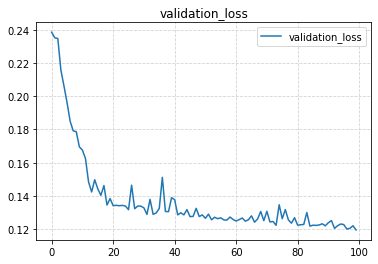

In [12]:
plt.plot(history.history['loss'], label = 'train_loss')
plt.title('train_loss')
plt.grid(color='lightgrey',linestyle='--')
plt.savefig('loss.png')
plt.legend()
plt.clf()

plt.plot(history.history['val_loss'], label = 'validation_loss')
plt.title('validation_loss')
plt.grid(color='lightgrey',linestyle='--')
plt.savefig('val_loss.png')
plt.legend()
# plt.clf()

# plt.plot(history.history['accuracy'], label = 'train_accuracy')
# plt.title('train_accuracy')
# plt.grid(color='lightgrey',linestyle='--')
# plt.savefig('acc.png')
# plt.legend()
# plt.clf()

# plt.plot(history.history['val_accuracy'], label = 'validation_accuracy')
# plt.title('validation_accuracy')
# plt.grid(color='lightgrey',linestyle='--')
# plt.savefig('val_acc.png')
# plt.legend()
# plt.clf()
